<a href="https://colab.research.google.com/github/rpdieego/Reinforcement_Learning/blob/master/Linear_RL_Trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Reinforcement Learning Trader

In [36]:
# import relevant libraries and packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

from sklearn.preprocessing import StandardScaler

#### Data

In [37]:
# Let's use AAPL (Apple), MSI (Motorola), SBUX (Starbucks)
def get_data():
  # returns a T x 3 list of stock prices
  # each row is a different stock
  # 0 = AAPL
  # 1 = MSI
  # 2 = SBUX
  url = 'https://raw.githubusercontent.com/rpdieego/Reinforcement_Learning/master/aapl_msi_sbux.csv'
  df = pd.read_csv(url)
  return df.values

In [38]:
### The experience replay memory ###
class ReplayBuffer:
  def __init__(self, obs_dim, act_dim, size):
    self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.acts_buf = np.zeros(size, dtype=np.uint8)
    self.rews_buf = np.zeros(size, dtype=np.float32)
    self.done_buf = np.zeros(size, dtype=np.uint8)
    self.ptr, self.size, self.max_size = 0, 0, size

  def store(self, obs, act, rew, next_obs, done):
    self.obs1_buf[self.ptr] = obs
    self.obs2_buf[self.ptr] = next_obs
    self.acts_buf[self.ptr] = act
    self.rews_buf[self.ptr] = rew
    self.done_buf[self.ptr] = done
    self.ptr = (self.ptr+1) % self.max_size
    self.size = min(self.size+1, self.max_size)

  def sample_batch(self, batch_size=32):
    idxs = np.random.randint(0, self.size, size=batch_size)
    return dict(s=self.obs1_buf[idxs],
                s2=self.obs2_buf[idxs],
                a=self.acts_buf[idxs],
                r=self.rews_buf[idxs],
                d=self.done_buf[idxs])

#### Scaler Object

In [39]:
def get_scaler(env):
  # return scikit-learn scaler object to scale the states

  states = []
  for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler

In [40]:
class LinearModel:
  """ A linear regression model """
  def __init__(self, input_dim, n_action):
    self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
    self.b = np.zeros(n_action)

    # momentum terms
    self.vW = 0
    self.vb = 0

    self.losses = []

  def predict(self, X):
    # make sure X is N x D
    assert(len(X.shape) == 2)
    return X.dot(self.W) + self.b

  def sgd(self, X, Y, learning_rate=0.01, momentum=0.9):
    # make sure X is N x D
    assert(len(X.shape) == 2)

    # the loss values are 2-D
    # normally we would divide by N only
    # but now we divide by N x K
    num_values = np.prod(Y.shape)

    # do one step of gradient descent
    # we multiply by 2 to get the exact gradient
    # (not adjusting the learning rate)
    # i.e. d/dx (x^2) --> 2x
    Yhat = self.predict(X)
    gW = 2 * X.T.dot(Yhat - Y) / num_values
    gb = 2 * (Yhat - Y).sum(axis=0) / num_values

    # update momentum terms
    self.vW = momentum * self.vW - learning_rate * gW
    self.vb = momentum * self.vb - learning_rate * gb

    # update params
    self.W += self.vW
    self.b += self.vb

    mse = np.mean((Yhat - Y)**2)
    self.losses.append(mse)

  def load_weights(self, filepath):
    npz = np.load(filepath)
    self.W = npz['W']
    self.b = npz['b']

  def save_weights(self, filepath):
    np.savez(filepath, W=self.W, b=self.b)

In [41]:
def maybe_make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

In [42]:
class MultiStockEnv:
  """
  A 3-stock trading environment.
  State: vector of size 7 (n_stock * 2 + 1)
    - # shares of stock 1 owned
    - # shares of stock 2 owned
    - # shares of stock 3 owned
    - price of stock 1 (using daily close price)
    - price of stock 2
    - price of stock 3
    - cash owned (can be used to purchase more stocks)
  Action: categorical variable with 27 (3^3) possibilities
    - for each stock, you can:
    - 0 = sell
    - 1 = hold
    - 2 = buy
  """
  def __init__(self, data, initial_investment=20000):
    # data
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    self.action_space = np.arange(3**self.n_stock)

    # action permutations
    # returns a nested list with elements like:
    # [0,0,0]
    # [0,0,1]
    # [0,0,2]
    # [0,1,0]
    # [0,1,1]
    # etc.
    # 0 = sell
    # 1 = hold
    # 2 = buy
    self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

    # calculate size of state
    self.state_dim = self.n_stock * 2 + 1

    self.reset()


  def reset(self):
    self.cur_step = 0
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price = self.stock_price_history[self.cur_step]
    self.cash_in_hand = self.initial_investment
    return self._get_obs()


  def step(self, action):
    assert action in self.action_space

    # get current value before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to the next day
    self.cur_step += 1
    self.stock_price = self.stock_price_history[self.cur_step]

    # perform the trade
    self._trade(action)

    # get the new value after taking the action
    cur_val = self._get_val()

    # reward is the increase in porfolio value
    reward = cur_val - prev_val

    # done if we have run out of data
    done = self.cur_step == self.n_step - 1

    # store the current value of the portfolio here
    info = {'cur_val': cur_val}

    # conform to the Gym API
    return self._get_obs(), reward, done, info


  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned
    obs[self.n_stock:2*self.n_stock] = self.stock_price
    obs[-1] = self.cash_in_hand
    return obs
    


  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand


  def _trade(self, action):
    # index the action we want to perform
    # 0 = sell
    # 1 = hold
    # 2 = buy
    # e.g. [2,1,0] means:
    # buy first stock
    # hold second stock
    # sell third stock
    action_vec = self.action_list[action]

    # determine which stocks to buy or sell
    sell_index = [] # stores index of stocks we want to sell
    buy_index = [] # stores index of stocks we want to buy
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)

    # sell any stocks we want to sell
    # then buy any stocks we want to buy
    if sell_index:
      # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0
    if buy_index:
      # NOTE: when buying, we will loop through each stock we want to buy,
      #       and buy one share at a time until we run out of cash
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1 # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False

In [43]:
class DQNAgent(object):
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.gamma = 0.95  # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = LinearModel(state_size, action_size)

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])  # returns action


  def train(self, state, action, reward, next_state, done):
    if done:
      target = reward
    else:
      target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

    target_full = self.model.predict(state)
    target_full[0, action] = target

    # Run one training step
    self.model.sgd(state, target_full)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay


  def load(self, name):
    self.model.load_weights(name)


  def save(self, name):
    self.model.save_weights(name)


def play_one_episode(agent, env, is_train):
  # note: after transforming states are already 1xD
  state = env.reset()
  state = scaler.transform([state])
  done = False

  while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    if is_train == 'train':
      agent.train(state, action, reward, next_state, done)
    state = next_state

  return info['cur_val']

In [44]:
# config
models_folder = 'linear_rl_trader_models'
rewards_folder = 'linear_rl_trader_rewards'
num_episodes = 2000
batch_size = 32
initial_investment = 20000


maybe_make_dir(models_folder)
maybe_make_dir(rewards_folder)

data = get_data()
n_timesteps, n_stocks = data.shape

n_train = n_timesteps // 2

train_data = data[:n_train]
test_data = data[n_train:]

env = MultiStockEnv(train_data, initial_investment)
state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)

# store the final value of the portfolio (end of episode)
portfolio_value = []





In [49]:
### test

# then load the previous scaler
with open(f'{models_folder}/scaler.pkl', 'rb') as f:
  scaler = pickle.load(f)

# remake the env with test data
env = MultiStockEnv(test_data, initial_investment)

# make sure epsilon is not 1!
# no need to run multiple episodes if epsilon = 0, it's deterministic
agent.epsilon = 0.01

# load trained weights
agent.load(f'{models_folder}/linear.npz')

# play the game num_episodes times
for e in range(num_episodes):
  t0 = datetime.now()
  val = play_one_episode(agent, env, 'test')
  dt = datetime.now() - t0
  print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
  portfolio_value.append(val) # append episode end portfolio value

episode: 1/2000, episode end value: 23859.02, duration: 0:00:00.078281
episode: 2/2000, episode end value: 28104.80, duration: 0:00:00.067256
episode: 3/2000, episode end value: 29061.36, duration: 0:00:00.061429
episode: 4/2000, episode end value: 23874.63, duration: 0:00:00.060598
episode: 5/2000, episode end value: 27226.91, duration: 0:00:00.078232
episode: 6/2000, episode end value: 28104.80, duration: 0:00:00.058860
episode: 7/2000, episode end value: 26955.33, duration: 0:00:00.059772
episode: 8/2000, episode end value: 29323.19, duration: 0:00:00.058706
episode: 9/2000, episode end value: 26543.79, duration: 0:00:00.065483
episode: 10/2000, episode end value: 30492.67, duration: 0:00:00.059840
episode: 11/2000, episode end value: 25199.13, duration: 0:00:00.067897
episode: 12/2000, episode end value: 26040.33, duration: 0:00:00.070338
episode: 13/2000, episode end value: 27478.53, duration: 0:00:00.079309
episode: 14/2000, episode end value: 33535.68, duration: 0:00:00.059406
e

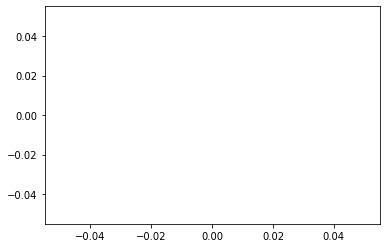

In [50]:
### train

# save the DQN
agent.save(f'{models_folder}/linear.npz')

# save the scaler
with open(f'{models_folder}/scaler.pkl', 'wb') as f:
  pickle.dump(scaler, f)

# plot losses
plt.plot(agent.model.losses)
plt.show()


# save portfolio value for each episode
np.save(f'{rewards_folder}/train.npy', portfolio_value)